# Predicting NFL Hall of Famers

## By John Harrigan and Evan Staffen 


# 1. Business Understanding

The ultimate recognition for an NFL player is to be inducted into the Hall of Fame. Only 1.2% of NFL players can call themselves Hall of Famers. While the avid football fan knows more than just this small fraction of players, Hall of Famers are the household names. They have influence way beyond their playing days and way outside the sphere of football.

Michael Strahan, former defensive back for the New York Giants is a host on the talk-show 'Live with Michael and Kelly'. Troy Polamalu, one of the all-time great safeties for the Pittsburgh Steelers, is still seen in Head & Shoulder's ads because of his famous, curly hair. Peyton Manning may be one of the prime examples of this. He was just the host of the Country Music Awards, acted in the animated movie 'Ferdinand' and has endorsement deals with various companies. 


We set out to create a model that can determine whether or not a player will make it to the Hall of Fame based on their career statistics.

    What are the most important metrics for determining whether a player will make it into the hall of fame?
    Who is near the the hall of fame status that is not there yet that should be targeted?

# 2. Datasets

Multiple datasets from different sources were used for this analysis. All of the datasets can be accessed from the data folder located within this repository.

Two datasets from Kaggle were used. One had basic demographics for 25K+ NFL players from 1950-2017. The other had indvidual game data for each player in the former dataset, with just above 1 million rows. 

7 separate datasets were taken from profootballreference.com so we could add the individual accolades for each player. 6 of these datasets were used to compile the MVP, DPOY, DROY, OPOY, OROY, Superbowl MVPs of each year into a new column which was the sum of everyone of those awards a player won in their career. The last dataset allowed us to create a column for our target, whether a player made the hall of fame as 1 or they didn't make the hall of fame as 0. 

* FIGURE OUT HOW TO CITE PROPERLY *

**JACK POSSIBLY DOING MORE WEB SCRAPING**

##### Necessary Imports

In [568]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from xgboost import XGBClassifier
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as Pipeline
from sklearn.metrics import plot_roc_curve, make_scorer, roc_auc_score, accuracy_score,precision_score, recall_score, f1_score, plot_confusion_matrix,classification_report
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn import set_config
set_config(display= 'diagram')

import warnings
warnings.filterwarnings('ignore')


# READING IN DATASET -- around 7 minutes

In [460]:
# Load in data

# Basic player information data
df = pd.read_json('./archive/nfl_players.json')

# Data for each player by individual game and sorting by year
df1 = pd.read_json('./archive/nfl_games.json')
df1 = df1.sort_values('year')

In [531]:
display(df.info(),df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25043 entries, 0 to 25042
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   player_id           25043 non-null  int64  
 1   name                25043 non-null  object 
 2   position            25043 non-null  object 
 3   height              24788 non-null  object 
 4   weight              24927 non-null  float64
 5   current_team        1881 non-null   object 
 6   birth_date          24879 non-null  object 
 7   birth_place         24151 non-null  object 
 8   death_date          6542 non-null   object 
 9   college             24893 non-null  object 
 10  high_school         23889 non-null  object 
 11  draft_team          15041 non-null  object 
 12  draft_round         15041 non-null  float64
 13  draft_position      15041 non-null  float64
 14  draft_year          15041 non-null  float64
 15  current_salary      1765 non-null   object 
 16  hof_

None

,player_id,name,position,height,weight,current_team,birth_date,birth_place,death_date,college,high_school,draft_team,draft_round,draft_position,draft_year,current_salary,hof_induction_year
0,1809,Robert Blackmon,DB,6-0,208.0,None,1967-05-12,"Bay City, TX",None,Baylor,"Van Vleck, TX",Seattle Seahawks,2.0,34.0,1990.0,None,NaN
1,23586,Dean Wells,LB,6-3,248.0,None,1970-07-20,"Louisville, KY",None,Kentucky,"Holy Cross, KY",Seattle Seahawks,4.0,85.0,1993.0,None,NaN
2,355,Kiko Alonso,ILB,6-3,238.0,Miami Dolphins,1990-08-14,"Newton, MA",None,Oregon,"Los Gatos, CA",Buffalo Bills,2.0,46.0,2013.0,"1,075,000",NaN
3,18182,Steve Ramsey,QB,6-2,210.0,None,1948-04-22,"Dallas, TX",1999-10-15,North Texas,"W.W. Samuell, TX",New Orleans Saints,5.0,126.0,1970.0,None,NaN
4,16250,Cory Nelms,CB,6-0,195.0,None,1988-02-27,"Neptune, NJ",None,Miami (FL),"Neptune, NJ",None,NaN,NaN,NaN,None,NaN


In [459]:
df1

,player_id,year,date,game_number,age,team,game_location,opponent,game_won,player_team_score,...,defense_interception_yards,defense_interception_touchdowns,defense_safeties,point_after_attemps,point_after_makes,field_goal_attempts,field_goal_makes,punting_attempts,punting_yards,punting_blocked
1006905,17752,1950,1950-10-15,4,23-179,CRD,A,CLE,False,24,...,0,0,0,0,0,0,0,0,0,0
431001,5948,1950,1950-11-12,8,23-097,WAS,H,PHI,False,0,...,0,0,0,0,0,0,0,0,0,0
431002,5948,1950,1950-11-26,10,23-111,WAS,H,BAL,True,38,...,0,0,0,0,0,0,0,0,0,0
431003,5948,1950,1950-12-03,11,23-118,WAS,A,PIT,True,24,...,0,0,0,0,0,0,0,0,0,0
431004,5948,1950,1950-12-10,12,23-125,WAS,H,CLE,False,21,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354164,12840,2017,2017-09-24,3,27-072,SEA,A,TEN,False,27,...,0,0,0,0,0,0,0,0,0,0
354163,12840,2017,2017-09-17,2,27-065,SEA,H,SFO,True,12,...,0,0,0,0,0,0,0,0,0,0
354162,12840,2017,2017-09-10,1,27-058,SEA,A,GNB,False,9,...,0,0,0,0,0,0,0,0,0,0
28467,11311,2017,2017-11-12,9,21-328,LAR,H,HOU,True,33,...,0,0,0,0,0,0,0,0,0,0


In [458]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1024164 entries, 1006905 to 616693
Data columns (total 46 columns):
 #   Column                           Non-Null Count    Dtype         
---  ------                           --------------    -----         
 0   player_id                        1024164 non-null  int64         
 1   year                             1024164 non-null  int64         
 2   date                             1024164 non-null  datetime64[ns]
 3   game_number                      1024164 non-null  int64         
 4   age                              1024164 non-null  object        
 5   team                             1024164 non-null  object        
 6   game_location                    1024164 non-null  object        
 7   opponent                         1024164 non-null  object        
 8   game_won                         1024164 non-null  bool          
 9   player_team_score                1024164 non-null  int64         
 10  opponent_score           

# 3. Data Preparation and EDA -- around 5 minutes


### Creating new columns in player df from games df
'total_games' = total games played throughout career

'win_percent' = 'games_won' / 'total_games'

'all_teams' = all teams the player has played a game for
    
    -- 'all_teams' is only a temporary column, we will ultimately make it so that each team is a column itself, with a one meaning the player has played for the team and a zero meaning they have not

In [701]:
# List of each unique player_id
all_players = df1.player_id.unique()

# Dictionary to hold player_id and total games played
total = {}

# Dictionary to hold player_id and win percentage
win_percent = {}

# Dictionary to hold player_id and each team they played for
teams = {}

# For loop to fill the dictionaries created above
for player in all_players:
    total[player] = len(df1[df1.player_id == player])
    win_percent[player] = round((len(df1[(df1.player_id == player) & (df1.game_won == True)])/total[player]) * 100, 2)
    teams[player] = list(df1[df1.player_id == player].team.unique())

# Creating dataframe with every players position and merging with games dataframe and dropping NAs
temp = df[['player_id', 'position']]
best = pd.merge(df1, temp, on = 'player_id', how = 'outer')
best.dropna(inplace = True)

# Getting career stats for every player and merging with the players dataframe and dropping NAs
best = best.groupby('player_id').agg('sum')
all_time = pd.merge(df, best, on = 'player_id', how = 'outer')
all_time.dropna(subset='year', inplace = True)

# Creating new columns from the dictionaries created in the above for loop
all_time['total_games'] = all_time['player_id'].map(lambda x: total[x])
all_time['win_percent'] = all_time['player_id'].map(lambda x: win_percent[x])
all_time['all_teams'] = all_time['player_id'].map(lambda x: teams[x])



### Convert 'position' into 6 subcategories

Because the 'position' column has over 411 categories, we decided to simplify the positions into 6 categories. Two of the categories were simplified based on offensive positions ('OL','PM'), two on defensive positions ('DL',DS'), one on special teams ('K') and the last for players with multiple positions ('MX'). Players with three or more positions, which made up a small fraction of the group, were dropped from the dataset.



In [551]:
all_time.position.value_counts()

DB             2907
LB             2308
WR             2048
RB             1941
DE             1034
               ... 
DE-DT-T-E         1
HB-FL-DB-WR       1
DE-C              1
RB-TE-LB          1
G-T-TE            1
Name: position, Length: 411, dtype: int64

TypeError: 'in <string>' requires string as left operand, not Series

In [552]:
# Function which takes players who only have 1 position listed in 
# their position column and binning them into smaller categories
def final_position(pos):
    
    # Offensive Linemen/Blockers
    ol = ['FB', 'HB', 'OG', 'OT', 'LG', 'LT', 'RG', 'RT', 'C', 'BB', 'T', 'G', 'B', 'G-T', 'T-G',
          'C-G', 'G-C', 'HB-DB', 'C-LB', 'WB', 'G-LB', 'OL', 'T-DT', 'FB-LB', 'C-T', 'C-G-T', 
          'HB-FB', 'FB-HB', 'LB-C', 'B-E']
    
    # Running backs, Wide Receivers, Tight Ends and Kick Returners
    playmakers = ['RB', 'WR', 'TE', 'KR', 'PR', 'TB', 'TB-HB', 'SE', 'FL']
    
    # Kickers and Punters
    feet = ['K', 'P']
    
    # Defensive Front
    d_front = ['DF', 'DT', 'LB', 'ILB', 'MLB', 'NT', 'OLB', 'LS', 'DB', 'DE', 'E', 'DE-DT', 'DT-DE', 
               'DB-HB', 'LB-C', 'E-DE', 'DE-E', 'LB-G', 'LB-DE', 'DE-LB', 'DL' 'DE-NT', 'DE-E',
               'DT-NT', 'DT-T', 'DB-WR', 'NT-DE', 'MG' , 'DG']
    
    # Defensive Backs
    d_back = ['S', 'FS' , 'SS', 'CB']
    
    if pos in ol:
        return 'OL'
    elif pos in playmakers:
        return 'PM'
    elif pos in feet:
        return 'K'
    elif pos in d_front:
        return 'DL'
    elif pos in d_back:
        return 'DS'
    elif ('K' in pos) | ('P' in pos):
        return 'K'
    else:
        return pos

# Applying function to 'position' column
all_time.position = all_time.position.map(lambda x: final_position(x))

# The only positions remaining are those that were still connected with '-'
# Making all players who have more than 3 positions listed as NANs
# Splitting the players positions so that if they have more than 1 but less than 3 they are labelled as MX
all_time.position = all_time['position'].map(lambda x: x if len(x.split('-')) < 4 else np.NAN)
all_time = all_time.dropna(subset = 'position')
all_time.position = all_time['position'].map(lambda x: (x.split('-')))
all_time.position = all_time['position'].map(lambda x: x[0] if len(x) < 2 else 'MX')
all_time.position = all_time['position'].map(lambda x: x if len(x) < 3 else np.NAN)
all_time = all_time.dropna(subset = 'position')

# Dropping irrelevant columns
all_time.drop(['death_date', 'college', 'hof_induction_year', 'year', 'high_school', 
               'current_salary', 'current_team','draft_team', 'draft_round', 'game_number', 
               'opponent_score', 'player_team_score'], axis = 1, inplace =True)

We will be dealing with the NaNs in those 3 columns later

In [560]:
all_time.isna().sum()

player_id                             0
name                                  0
position                              0
height                                4
weight                                4
birth_date                            0
birth_place                         494
draft_position                     6116
draft_year                         6116
passing_attempts                      0
passing_completions                   0
passing_yards                         0
passing_rating                        0
passing_touchdowns                    0
passing_interceptions                 0
passing_sacks                         0
passing_sacks_yards_lost              0
rushing_attempts                      0
rushing_yards                         0
rushing_touchdowns                    0
receiving_targets                     0
receiving_receptions                  0
receiving_yards                       0
receiving_touchdowns                  0
kick_return_attempts                  0


In [583]:
# Creating copy of all_time dataframe and using people for preprocessing here on out

people = all_time.copy()

#### Creating 'winner' column for if a player won the Superbowl
This was done using the fact that the Superbowl is the only game played at a neutral location

In [584]:
# Column of superbowl winners based on the fact that the game must have been at a neutral location
winners = df1[(df1.game_location == 'N') & (df1.game_won == True)].player_id.value_counts()
sub = dict(zip(winners.index, winners.values))
people['super_wins'] = people.player_id.map(lambda x: sub[x] if x in sub.keys() else 0)

In [585]:
people['super_wins'].value_counts()

0    17511
1     1159
2      312
3       71
4       28
5        2
Name: super_wins, dtype: int64

#### Datatype changes

In [586]:
# Dropping NAs since there were only 4 rows missing this information and they were the same
people.dropna(subset = ['height', 'weight'], inplace = True)

# Changing birth_date column to date_time object and then ordinal
people.birth_date = pd.to_datetime(people.birth_date)
people['birth_date'] = people['birth_date'].apply(lambda x: x.toordinal())

# Reformatting and changing height to a int
people['height'] = people['height'].map(lambda x: (int(x.split('-')[0]) * 12) + int(x.split('-')[1])).astype(int)

In [587]:
people.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19079 entries, 0 to 25042
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   player_id                        19079 non-null  int64  
 1   name                             19079 non-null  object 
 2   position                         19079 non-null  object 
 3   height                           19079 non-null  int64  
 4   weight                           19079 non-null  float64
 5   birth_date                       19079 non-null  int64  
 6   birth_place                      18585 non-null  object 
 7   draft_position                   12963 non-null  float64
 8   draft_year                       12963 non-null  float64
 9   passing_attempts                 19079 non-null  float64
 10  passing_completions              19079 non-null  float64
 11  passing_yards                    19079 non-null  float64
 12  passing_rating    

#### Creating a new column for each NFL team

In [588]:
# List of all current NFL teams
nfl_teams = ['SEA', 'BUF', 'NOR', 'DEN', 'NYJ', 'GNB', 'HOU', 'CLE', 'MIN', 'KAN', 'NYG', 'PIT',
             'PHI', 'LAR', 'TAM', 'NWE', 'CHI', 'SFO', 'IND', 'ATL', 'DET', 'ARI', 'CIN', 'BAL',
             'MIA', 'WAS', 'JAX', 'DAL', 'TEN', 'CAR', 'RAI', 'LAC']

# Creating new columns for each team, setting each row equal to zero
for team in nfl_teams:
    people[team] = 0

# For loop which adds 1 to column for a team if the player has played for them, based on the all_teams column
row_num = 0
for teams in list(people.all_teams):
    for team in teams:
        if team in nfl_teams:
            people[team][row_num] = 1
            
    row_num += 1

In [693]:
people[people.position == 'K']

,player_id,name,position,height,weight,birth_date,birth_place,draft_position,draft_year,passing_attempts,...,MIA,WAS,JAX,DAL,TEN,CAR,RAI,LAC,Awards,target
47,20499,Dave Smigelsky,K,71,180.0,715328,"Perth Amboy, NJ",NaN,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
64,5803,Rick Donnelly,K,72,195.0,716377,"Miller Place, NY",NaN,NaN,0.0,...,0,0,0,1,0,0,0,0,0,0
78,22616,Matt Turk,K,77,243.0,718599,"Milwaukee, WI",NaN,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
121,532,Zenon Andrusyshyn,K,74,210.0,711182,"Gunzburg, Germany",231.0,1970.0,0.0,...,0,0,0,0,0,0,0,0,0,0
195,23478,Herman Weaver,K,76,210.0,711448,"Villa Rica, GA",227.0,1970.0,5.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24807,19941,Rafael Septien,K,70,176.0,713299,"Mexico City, Mexico",258.0,1977.0,0.0,...,0,0,0,0,0,0,0,0,0,0
24824,21404,Pete Stoyanovich,K,71,187.0,718184,"Dearborn, MI",203.0,1989.0,0.0,...,0,0,0,0,0,0,0,0,0,0
24826,17200,Mike Patrick,K,72,209.0,712837,"Austin, TX",NaN,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0
24854,538,Bryan Anger,K,75,208.0,726016,"Camarillo, CA",70.0,2012.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [589]:
list(people.columns)

['player_id',
 'name',
 'position',
 'height',
 'weight',
 'birth_date',
 'birth_place',
 'draft_position',
 'draft_year',
 'passing_attempts',
 'passing_completions',
 'passing_yards',
 'passing_rating',
 'passing_touchdowns',
 'passing_interceptions',
 'passing_sacks',
 'passing_sacks_yards_lost',
 'rushing_attempts',
 'rushing_yards',
 'rushing_touchdowns',
 'receiving_targets',
 'receiving_receptions',
 'receiving_yards',
 'receiving_touchdowns',
 'kick_return_attempts',
 'kick_return_yards',
 'kick_return_touchdowns',
 'punt_return_attempts',
 'punt_return_yards',
 'punt_return_touchdowns',
 'defense_sacks',
 'defense_tackles',
 'defense_tackle_assists',
 'defense_interceptions',
 'defense_interception_yards',
 'defense_interception_touchdowns',
 'defense_safeties',
 'point_after_attemps',
 'point_after_makes',
 'field_goal_attempts',
 'field_goal_makes',
 'punting_attempts',
 'punting_yards',
 'punting_blocked',
 'total_games',
 'win_percent',
 'all_teams',
 'super_wins',
 'SEA',

### Creating Awards Column

Using the profootballreference database, we were able to gather information on each of these 6 awards given at the end of each season. From there we added a new column to the _people_ dataframe titled 'Awards', which was a sum of all of these 6 awards won by every player



In [590]:
# Defensive Player of the Year
dpoy = pd.read_csv('./Extras/dpoy.txt')

# Defensive Rookie of the Year
droy = pd.read_csv('./Extras/droy.txt')

# Most Valuable Player
mvps = pd.read_csv('./Extras/mvps.txt')

# Offensive Player of the Year
opoy = pd.read_csv('./Extras/opoy.txt')

# Offensive Rookie of the Year
oroy = pd.read_csv('./Extras/oroy.txt')

# Superbowl Most Valuable Player and first 5 rows
superbowlmvp = pd.read_csv('./Extras/superbowlmvp.txt')
superbowlmvp.head()

,Year,Lg,Pos,Player,Tm,Player-additional
0,2021,NFL,WR,Cooper Kupp,Los Angeles Rams,KuppCo00
1,2020,NFL,QB,Tom Brady,Tampa Bay Buccaneers,BradTo00
2,2019,NFL,QB,Patrick Mahomes,Kansas City Chiefs,MahoPa00
3,2018,NFL,WR,Julian Edelman,New England Patriots,EdelJu00
4,2017,NFL,QB,Nick Foles,Philadelphia Eagles,FoleNi00


In [591]:
# Organizing by defensive award winners, offensive award winners and mvps
dfence = dpoy.tail(47).Player.tolist() + droy.tail(52).Player.tolist()
ofence = opoy.tail(46).Player.tolist() + oroy.tail(51).Player.tolist()
mvp = mvps.tail(62).Player.tolist() + superbowlmvp.tail(53).Player.tolist()

# Combining lists into one series
awards = pd.Series(dfence + ofence + mvp)
aw_tot = awards.value_counts()
aw_dict = dict(zip(aw_tot.index, aw_tot.values))

# Lambda function creaeting new column with the players awards count
people['Awards'] = people.name.map(lambda x: aw_dict[x] if x in aw_dict.keys() else 0)

In [592]:
people['Awards'].value_counts()

0    18891
1      134
2       25
3       21
4        3
5        3
8        1
6        1
Name: Awards, dtype: int64

### Creating 'target' column
Using the profootballreference database we were able to create the 'target' column which would indicate if a player was inducted to the hall of fame or not 

-- 1 = Hall of fame

-- 0 = Not in hall of fame

In [593]:
# Creating new column for players who made it into the Hall of Fame labelled 'target'
hof = pd.read_csv('./archive/hallOfFame')
hall_of_fame = hof['Unnamed: 1']
fame = hall_of_fame.tolist()
people['target'] = people.name.map(lambda x: 1 if (x in fame) else 0)

In [594]:
people['target'].value_counts(normalize=True)

0    0.98805
1    0.01195
Name: target, dtype: float64

In [595]:
list(people.columns)

['player_id',
 'name',
 'position',
 'height',
 'weight',
 'birth_date',
 'birth_place',
 'draft_position',
 'draft_year',
 'passing_attempts',
 'passing_completions',
 'passing_yards',
 'passing_rating',
 'passing_touchdowns',
 'passing_interceptions',
 'passing_sacks',
 'passing_sacks_yards_lost',
 'rushing_attempts',
 'rushing_yards',
 'rushing_touchdowns',
 'receiving_targets',
 'receiving_receptions',
 'receiving_yards',
 'receiving_touchdowns',
 'kick_return_attempts',
 'kick_return_yards',
 'kick_return_touchdowns',
 'punt_return_attempts',
 'punt_return_yards',
 'punt_return_touchdowns',
 'defense_sacks',
 'defense_tackles',
 'defense_tackle_assists',
 'defense_interceptions',
 'defense_interception_yards',
 'defense_interception_touchdowns',
 'defense_safeties',
 'point_after_attemps',
 'point_after_makes',
 'field_goal_attempts',
 'field_goal_makes',
 'punting_attempts',
 'punting_yards',
 'punting_blocked',
 'total_games',
 'win_percent',
 'all_teams',
 'super_wins',
 'SEA',

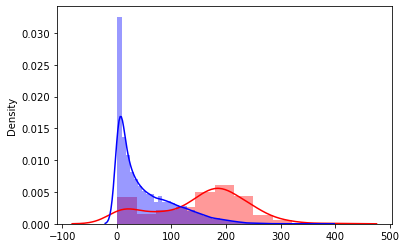

In [689]:
fig,ax = plt.subplots()


sns.distplot(x=hof['total_games'],color = 'r')
sns.distplot(x=not_hof['total_games'],color ='b');

# MIGHT NEED TO COMBINE TOUCHDOWNS INTO ONE CATEGORY

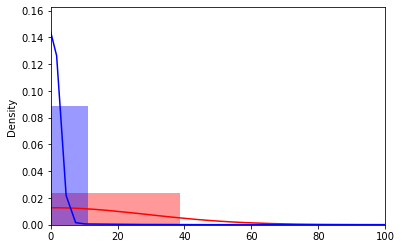

In [695]:
fig,ax = plt.subplots()
sns.distplot(x=hof['passing_touchdowns'],color = 'r')
sns.distplot(x=not_hof['passing_touchdowns'],color ='b')
ax.set_xlim(0,100);

# rushing yards taking into account quarterbacks getting sacked, think it should be total yards...

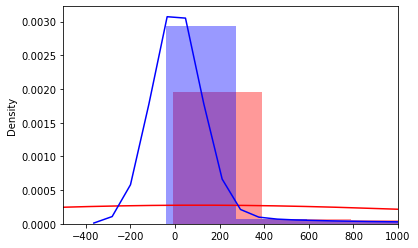

In [700]:
fig,ax = plt.subplots()
sns.distplot(x=hof['rushing_yards'],color = 'r')
sns.distplot(x=not_hof['rushing_yards'],color ='b')
ax.set_xlim(-500,1000);

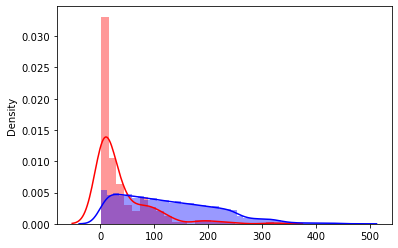

In [673]:
fig,ax = plt.subplots()

sns.distplot(x=hof['draft_position'],color = 'r')
sns.distplot(x=not_hof['draft_position'],color ='b');

<AxesSubplot:xlabel='Awards', ylabel='Count'>

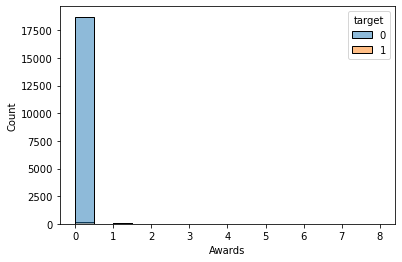

In [635]:
sns.scatterplop(data=people,x='Awards',hue='target').set_xlim

# Imputations -- DATA LEAKAGE BABAYY

## thinking it might be easiest to just do these steps individually after train-test-split 
### I cannot figure out how to put birth_location fxn into simple imputer
## Should be just replacing people with x_train and x_test respectively
## Will put that code in markdown under train_test_split




In [544]:
for col in people.columns:
    if people[col].isna().sum() != 0:
        print(col,people[col].isna().sum())

birth_place 494
draft_position 6116
draft_year 6116


In [ ]:
# Filling NAs in birth_place with unknown
people.birth_place = people.birth_place.fillna('unknown')



# Inputing players draft years who were undrafted as 20 years after their birth date
# Players cannot be drafted until they've played college football for at least 3 years, so this is a fair assumption
und = people[people.draft_year.isna()] 
und['draft_year'] = und.birth_date.map(lambda x: x.year + 20)
people[people.draft_year.isna()] = und

# Labeling their position in the draft as 400
people.draft_position.fillna(400, inplace = True)



#### Separating 'birth_place' into 7 different categories, 6 in America and the rest are considered International 

In [ ]:
# Function which separates America into 6 separate regions
    # NE = North East
    # NW = North West
    # SM = South Middle
    # NM = North Middle
    # SE = South East
    # SW = South West
    # IN = International

def birth_location(loc):
    ne = ['ME', 'NH', 'VT', 'MA', 'NJ','CT', 'NY','DE', 'PA', 'MY', 'VA','RI','OH','WV']
    nw = ['WA', 'OR', 'ID', 'MT', 'WY','AK']
    nm = ['ND', 'SD','NE','IA','MN','WI','IL','IN','MI']
    sm = ['TX', 'OK', 'KS', 'MO', 'AR', 'NE','LA']
    se = ['FL', 'GA' , 'AL', 'MS','SC','NC','KY']
    sw = ['CA','NV','UT','AZ','NM','CO','HI']
    if loc in ne:
        return 'NE'
    elif loc in nw:
        return 'NW'
    elif loc in nm:
        return 'NM'
    elif loc in sm:
        return 'SM'
    elif loc in se:
        return 'SE'
    elif loc in sw:
        return 'SW'
    else:
        return 'IN'
    
people.birth_place = people.birth_place.map(lambda x: birth_location(x[-2:]))

# 4. Train-Test-Split

#### Due to the imbalance of the dataset, hall of famers only being 1.2% of all NFL players, we used the stratify parameter of train-test-split

In [100]:
y = people.target
X = people.drop(['target','player_id','name','all_teams'], axis =1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =42,stratify=y)

# SAME CODE AS IMPUTATION BLOCK, JUST DONE ON TRAIN AND TEST SEPARATELY

##### Training 

x_train.birth_place = x_train.birth_place.fillna('unknown')
und = x_train[people.draft_year.isna()] 
und['draft_year'] = und.birth_date.map(lambda x: x.year + 20)
x_train[people.draft_year.isna()] = und
x_train.draft_position.fillna(400, inplace = True)

##### Testing 

x_test.birth_place = x_test.birth_place.fillna('unknown')
und = x_test[people.draft_year.isna()] 
und['draft_year'] = und.birth_date.map(lambda x: x.year + 20)
x_test[people.draft_year.isna()] = und
x_test.draft_position.fillna(400, inplace = True)

##### Function
def birth_location(loc):
    ne = ['ME', 'NH', 'VT', 'MA', 'NJ','CT', 'NY','DE', 'PA', 'MY', 'VA','RI','OH','WV']
    nw = ['WA', 'OR', 'ID', 'MT', 'WY','AK']
    nm = ['ND', 'SD','NE','IA','MN','WI','IL','IN','MI']
    sm = ['TX', 'OK', 'KS', 'MO', 'AR', 'NE','LA']
    se = ['FL', 'GA' , 'AL', 'MS','SC','NC','KY']
    sw = ['CA','NV','UT','AZ','NM','CO','HI']
    if loc in ne:
        return 'NE'
    elif loc in nw:
        return 'NW'
    elif loc in nm:
        return 'NM'
    elif loc in sm:
        return 'SM'
    elif loc in se:
        return 'SE'
    elif loc in sw:
        return 'SW'
    else:
        return 'IN'

##### Lambda
x_train.birth_place = x_train.birth_place.map(lambda x: birth_location(x[-2:]))
x_test.birth_place = x_test.birth_place.map(lambda x: birth_location(x[-2:]))

# 5. Pipeline

#### We only need to create two pipelines in this case. One for the numerical data and the other for the categorical data


## Column Transformers

In [7]:
# Numeric pipeline
numeric_pipeline = Pipeline([('ss', StandardScaler())])

# Categorical pipeline
categorical_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False, drop = 'first',handle_unknown='ignore')), ('ss', StandardScaler())])

# Separating columns into categoricals and numericals, no ordinals in our dataset
cats = ['position', 'birth_place']
nums = X.drop(['position', 'birth_place'],axis=1).columns

# Creating ColumnTransformer
ct = ColumnTransformer(
[("catpipe", categorical_pipeline, cats),
("numpipe", numeric_pipeline, nums)])

# 6. Model Selection

## Model 1 - Basic Logistic Regression

Training Accuracy:  0.9906402096593037 
 Testing Accuracy:  0.9877707896575821 
 
 Training Recall:  0.33125 
Testing Recall:  0.19117647058823528 
 
Training Precision:  0.7464788732394366 
 Testing Precision:  0.4642857142857143 
 
 Training F1 Score:  0.4588744588744589 
 Testing F1 Score:  0.27083333333333337 



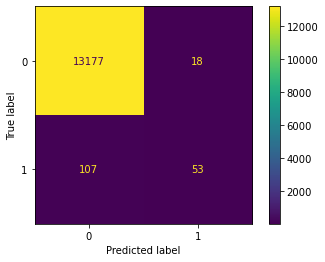

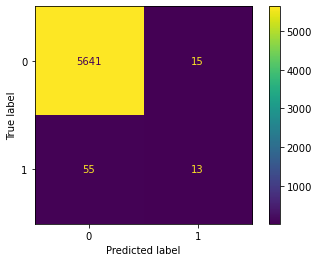

In [455]:
first_pipe = Pipeline([('preprocess', ct),
                      ('model',
                       LogisticRegression(max_iter=1000,random_state=42))])

first_pipe.fit(x_train,y_train)

# Training predictions
train_preds = first_pipe.predict(x_train)

# Testing predictions
test_preds = first_pipe.predict(x_test)

# Training confusion matrix
plot_confusion_matrix(first_pipe,x_train,y_train)

# Testing confusion matrix
plot_confusion_matrix(first_pipe,x_test,y_test)

# Training ROC curve
plot_roc_curve(first_pipe,x_train,y_train)

# Testing ROC curve
plot_roc_curve(first_pipe,x_train,y_train)

print('Training Accuracy: ', accuracy_score(y_train,train_preds),'\n', 
      'Testing Accuracy: ', accuracy_score(y_test,test_preds),'\n \n',

'Training Recall: ',recall_score(y_train,train_preds),'\n'
'Testing Recall: ',recall_score(y_test,test_preds),'\n \n'

'Training Precision: ',precision_score(y_train,train_preds),'\n',
'Testing Precision: ',precision_score(y_test,test_preds),'\n \n',

'Training F1 Score: ',f1_score(y_train,train_preds),'\n',
'Testing F1 Score: ',f1_score(y_test,test_preds),'\n')

## Model 2 - Logistic Regression with SMOTE

Training Accuracy:  0.9238487457880944 
 Testing Accuracy:  0.9238294898672257 
 
 Training Recall:  0.9294871794871795 
Testing Recall:  0.8333333333333334 
 
Training Precision:  0.1259774109470026 
 Testing Precision:  0.12396694214876033 
 
 Training F1 Score:  0.22188217291507265 
 Testing F1 Score:  0.2158273381294964 



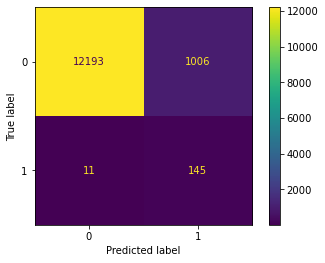

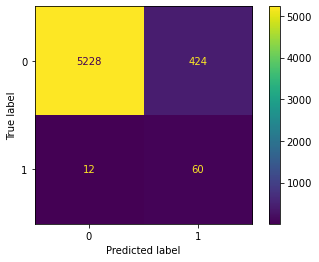

In [9]:
first_pipe_smote = Pipeline([('preprocess', ct),
                          ('smote',SMOTE(random_state=42)),
                      ('model',
                       LogisticRegression(max_iter=1000,random_state=42))])

first_pipe_smote.fit(x_train,y_train)

train_preds = first_pipe_smote.predict(x_train)
test_preds = first_pipe_smote.predict(x_test)

plot_confusion_matrix(first_pipe_smote,x_train,y_train)

plot_confusion_matrix(first_pipe_smote,x_test,y_test)

plot_roc_curve(first_pipe_smote,x_train,y_train)

plot_roc_curve(first_pipe_smote,x_test,y_test)

print('Training Accuracy: ', accuracy_score(y_train,train_preds),'\n',
'Testing Accuracy: ', accuracy_score(y_test,test_preds),'\n \n',

'Training Recall: ',recall_score(y_train,train_preds),'\n'
'Testing Recall: ',recall_score(y_test,test_preds),'\n \n'

'Training Precision: ',precision_score(y_train,train_preds),'\n',
'Testing Precision: ',precision_score(y_test,test_preds),'\n \n',

'Training F1 Score: ',f1_score(y_train,train_preds),'\n',
'Testing F1 Score: ',f1_score(y_test,test_preds),'\n')

## Model 3 - Logistic Regression with SMOTE

## Block below shows best params found from Jack's CV

Best params:  {'model__C': 50, 'model__class_weight': 'balanced', 'model__max_iter': 900, 'model__solver': 'lbfgs', 'model__warm_start': True} 
 Best score:  0.9345563459378511

In [ ]:
log_grid_pipe = Pipeline([('preprocess', ct),
                          ('smote',SMOTE(random_state=42)),
                      ('model',
                       LogisticRegression(random_state=42))])

log_params = {'model__C': [.01, .1, 1, 10],
         'model__solver': ['sag','saga','lbfgs'],
         'model__max_iter': [1000,10000]}
cv = GridSearchCV(estimator = log_grid_pipe, param_grid = log_params, cv = 5)
cv.fit(x_train, y_train)

In [12]:
best_log = cv.best_params_
best_log_estim = cv.best_estimator_
print('Best params: ',cv.best_params_,'\n Best score: ',cv.best_score_)
best_log_estim

Best params:  {'model__C': 10, 'model__max_iter': 1000, 'model__solver': 'lbfgs'} 
 Best score:  0.926169973792587


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('catpipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['position', 'birth_place']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['height', 'weight', 'birth_date', 'draft_position', 'draft_year',
       'passing_atte...
       'punting_blocked', 'total_games', 'win_percent', 'super_wins', 'SEA',
       'BUF', 'NOR', 'DEN', 'NYJ', 'GNB', 'HOU', 'CLE', 'MIN', 'KAN', 'NYG',
       'PIT', 'PHI', 'LAR', 'TAM', 'NWE', 'CHI', 'SFO', 'IND', 'ATL', 'DET',
       'ARI', 'CIN', 'BAL', 'MIA', 'WAS', 'JAX', 'DAL', 'TEN', 'CAR', 'RAI',
       'LAC'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 LogisticRegression(C=10, max_iter=1000, random_state=42))])

Training Accuracy:  0.9257207038562336 
 Testing Accuracy:  0.9247030048916841 
 
 Training Recall:  0.9230769230769231 
Testing Recall:  0.7916666666666666 
 
Training Precision:  0.12811387900355872 
 Testing Precision:  0.12050739957716702 
 
 Training F1 Score:  0.225 
 Testing F1 Score:  0.2091743119266055 



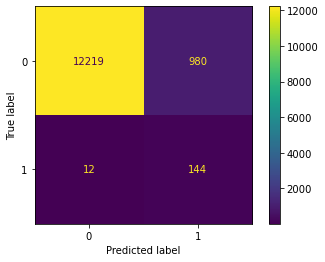

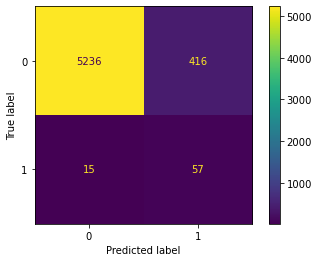

In [14]:
train_preds = best_log_estim.predict(x_train)
test_preds = best_log_estim.predict(x_test)

plot_confusion_matrix(best_log_estim,x_train,y_train)

plot_confusion_matrix(best_log_estim,x_test,y_test)

plot_roc_curve(best_log_estim,x_train,y_train)

plot_roc_curve(best_log_estim,x_test,y_test)

print('Training Accuracy: ', accuracy_score(y_train,train_preds),'\n',
'Testing Accuracy: ', accuracy_score(y_test,test_preds),'\n \n',

'Training Recall: ',recall_score(y_train,train_preds),'\n'
'Testing Recall: ',recall_score(y_test,test_preds),'\n \n'

'Training Precision: ',precision_score(y_train,train_preds),'\n',
'Testing Precision: ',precision_score(y_test,test_preds),'\n \n',

'Training F1 Score: ',f1_score(y_train,train_preds),'\n',
'Testing F1 Score: ',f1_score(y_test,test_preds),'\n')



# FINDING COEFFS FROM LOGREG -- USE TO JUSTIFY DROPPING 
# FIRST PIPE IS RIDGE, SECOND IS LASSO
# DEFENSE_INTERCEPTIONS_TOUCHDOWN IS COLUMN CONSIDERED WORTH DROPPING

In [326]:
log_grid_pipe = Pipeline([('preprocess', ct),
                          ('smote',SMOTE(random_state=42)),
                      ('model',
                       LogisticRegression(random_state=42, C=50,class_weight ='balanced', max_iter= 900, solver= 'lbfgs', warm_start= True))])

log_grid_pipe.fit(x_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('catpipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['position', 'birth_place']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['height', 'weight', 'birth_date', 'draft_position', 'draft_year',
       'passing_atte...
       'punting_blocked', 'total_games', 'win_percent', 'super_wins', 'SEA',
       'BUF', 'NOR', 'DEN', 'NYJ', 'GNB', 'HOU', 'CLE', 'MIN', 'KAN', 'NYG',
       'PIT', 'PHI', 'LAR', 'TAM', 'NWE', 'CHI', 'SFO', 'IND', 'ATL', 'DET',
       'ARI', 'CIN', 'BAL', 'MIA', 'WAS', 'JAX', 'DAL', 'TEN', 'CAR', 'RAI',
       'LAC'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 LogisticRegression(C=50, class_weight='balanced', max_iter=900,
                                    random_state=42, warm_start=True))])

In [440]:
log_grid_pipe = Pipeline([('preprocess', ct),
                          ('smote',SMOTE(random_state=42)),
                      ('model',
                       LogisticRegression(random_state=42, C=50,penalty='l1',class_weight ='balanced', max_iter= 900, solver= 'saga', warm_start= True))])

log_grid_pipe.fit(x_train,y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('catpipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['position', 'birth_place']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['height', 'weight', 'birth_date', 'draft_position', 'draft_year',
       'passing_atte...
       'BUF', 'NOR', 'DEN', 'NYJ', 'GNB', 'HOU', 'CLE', 'MIN', 'KAN', 'NYG',
       'PIT', 'PHI', 'LAR', 'TAM', 'NWE', 'CHI', 'SFO', 'IND', 'ATL', 'DET',
       'ARI', 'CIN', 'BAL', 'MIA', 'WAS', 'JAX', 'DAL', 'TEN', 'CAR', 'RAI',
       'LAC'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 LogisticRegression(C=50, class_weight='balanced', max_iter=900,
                                    penalty='l1', random_state=42,
                                    solver='saga', warm_start=True))])

In [449]:
log_grid_pipe[:-1].get_feature_names_out()
log_grid_pipe.named_steps.model.coef_

#for loop for dict with column names and coef
counter = 0
coefs = {}
for num in range(0,len(log_grid_pipe[:-1].get_feature_names_out())):
    coefs[log_grid_pipe[:-1].get_feature_names_out()[num]]= log_grid_pipe.named_steps.model.coef_[0][num]
    counter += 1

coefs

{'catpipe__position_DS': 0.36851607967918065,
 'catpipe__position_K': -0.8012002567872826,
 'catpipe__position_MX': 0.113311215810716,
 'catpipe__position_OL': 0.11521615816821343,
 'catpipe__position_PM': 1.690291773299881,
 'catpipe__position_QB': -0.34141516509336617,
 'catpipe__birth_place_NE': -0.8946490458248912,
 'catpipe__birth_place_NM': -0.7316487867924159,
 'catpipe__birth_place_NW': -0.3761348121645384,
 'catpipe__birth_place_SE': -0.808188213094468,
 'catpipe__birth_place_SM': -0.9234767472185864,
 'catpipe__birth_place_SW': -0.7431116402426537,
 'numpipe__height': -0.15417985191824565,
 'numpipe__weight': 2.731347756406751,
 'numpipe__birth_date': 0.9143232992783806,
 'numpipe__draft_position': -0.9720242451745674,
 'numpipe__draft_year': -4.97284615713308,
 'numpipe__passing_attempts': 1.3987393453714612,
 'numpipe__passing_completions': -1.768284286329022,
 'numpipe__passing_yards': 0.11340936367797158,
 'numpipe__passing_rating': 1.0191426007546727,
 'numpipe__passing_

## Model Four - XGBoost

### APPROXIMATELY 7-8 MINUTES
    
https://www.kaggle.com/code/saxinou/imbalanced-data-xgboost-tunning

In [150]:
xg_params = {'model__max_depth': [3,4,5], 
        'model__learning_rate': [.1, .2],
        'model__gamma': [0,0.1], 
        'model__n_estimators': [50],
        'model__scale_pos_weight': [0.1,0.2]}

xg_pipe = Pipeline([('preprocess', ct),
                    ('smote',SMOTE(random_state=42)),
                      ('model',
                       XGBClassifier(random_state=42,eval_metric=['error']))])

xgcv = GridSearchCV(estimator = xg_pipe, scoring='balanced_accuracy', param_grid = xg_params, cv = 3)
xgcv.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('catpipe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['position',
                                                                          'birth_place']),
                                                                        ('numpipe',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['height', 'weight', 'birth_date', 'draft_position...
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=42,
                                                      reg_alpha=None,
                                                      reg_lambda=None,
                                                      scale_pos_weight=None,
                                                      subsample=None,
                                                      tree_method=None,
                                                      validate_parameters=None,
                                                      verbosity=None))]),
             param_grid={'model__gamma': [0, 0.1],
                         'model__learning_rate': [0.1, 0.2],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [50],
                         'model__scale_pos_weight': [0.1, 0.2]},
             scoring='balanced_accuracy')

In [155]:
results = pd.DataFrame(xgcv.cv_results_).sort_values(by = 'rank_test_score')
results['params'][0]

{'model__gamma': 0,
 'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 50,
 'model__scale_pos_weight': 0.1}

In [156]:
xg_pipe = Pipeline([('preprocess', ct),
                    ('smote',SMOTE(random_state=42)),
                      ('model',
                       XGBClassifier(random_state=42,eval_metric='error',gamma=0,learning_rate=0.1,
                                    max_depth=4,n_estimators=50,scale_pos_weight=0.1))])

xg_pipe.fit(x_train,y_train)

plot_confusion_matrix(xg_pipe,x_train,y_train)

plot_confusion_matrix(xg_pipe,x_test,y_test)

plot_roc_curve(xg_pipe,x_train,y_train)

plot_roc_curve(xg_pipe,x_test,y_test)

train_preds = xg_pipe.predict(x_train)
test_preds = xg_pipe.predict(x_test)

print('Training Accuracy: ', accuracy_score(y_train,train_preds),'\n',
'Testing Accuracy: ', accuracy_score(y_test,test_preds),'\n \n',

'Training Recall: ',recall_score(y_train,train_preds),'\n'
'Testing Recall: ',recall_score(y_test,test_preds),'\n \n'

'Training Precision: ',precision_score(y_train,train_preds),'\n',
'Testing Precision: ',precision_score(y_test,test_preds),'\n \n',

'Training F1 Score: ',f1_score(y_train,train_preds),'\n',
'Testing F1 Score: ',f1_score(y_test,test_preds),'\n')

Training Accuracy:  0.9907899663047548 
 Testing Accuracy:  0.9868972746331237 
 
 Training Recall:  0.41875 
Testing Recall:  0.16176470588235295 
 
Training Precision:  0.6907216494845361 
 Testing Precision:  0.3793103448275862 
 
 Training F1 Score:  0.5214007782101168 
 Testing F1 Score:  0.22680412371134023 



## Model 5 - C-SUPPORT VECTOR CLASSIFICATION
https://dhirajkumarblog.medium.com/top-4-advantages-and-disadvantages-of-support-vector-machine-or-svm-a3c06a2b107
https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/#h2_3
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

increases the cost of classification mistakes on the minority class.

In [72]:
from sklearn.svm import SVC

In [76]:
svc_pipe = Pipeline([('preprocess', ct),
                    ('smote',SMOTE(random_state=42)),
                      ('model',
                       SVC(random_state=42,class_weight='balanced',probability=True))])

svc_pipe.fit(x_train,y_train)

train_preds = svc_pipe.predict(x_train)
test_preds = svc_pipe.predict(x_test)

print('Training Accuracy: ', accuracy_score(y_train,train_preds),'\n',
'Testing Accuracy: ', accuracy_score(y_test,test_preds),'\n \n',

'Training Recall: ',recall_score(y_train,train_preds),'\n'
'Testing Recall: ',recall_score(y_test,test_preds),'\n \n'

'Training Precision: ',precision_score(y_train,train_preds),'\n',
'Testing Precision: ',precision_score(y_test,test_preds),'\n \n',

'Training F1 Score: ',f1_score(y_train,train_preds),'\n',
'Testing F1 Score: ',f1_score(y_test,test_preds),'\n')

Training Accuracy:  0.964208161737177 
 Testing Accuracy:  0.956848357791754 
 
 Training Recall:  0.9935897435897436 
Testing Recall:  0.4722222222222222 
 
Training Precision:  0.24525316455696203 
 Testing Precision:  0.13991769547325103 
 
 Training F1 Score:  0.3934010152284264 
 Testing F1 Score:  0.21587301587301588 



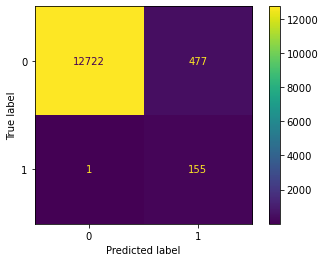

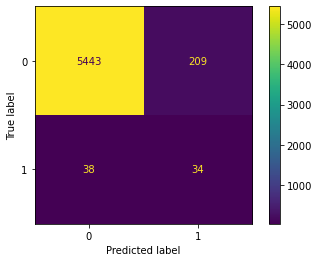

In [77]:
plot_confusion_matrix(svc_pipe,x_train,y_train)

plot_confusion_matrix(svc_pipe,x_test,y_test)

# New gridsearch with narrowed down hyperparams

#### did worse w scoring as roc_auc
Best params:  {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'rbf'} 
 Best score:  0.9274667442033605

In [340]:
svc_params = {'model__C': [0.1],
         'model__gamma': ['scale'],
         'model__kernel': ['rbf']}

svc_pipe = Pipeline([('preprocess', ct),
                    ('smote',SMOTE(random_state=42)),
                      ('model',
                       SVC(random_state=42,class_weight='balanced',probability=True))])
cvsvc = GridSearchCV(estimator = svc_pipe, scoring = 'recall', param_grid = svc_params, cv = 3)
cvsvc.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('catpipe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['position',
                                                                          'birth_place']),
                                                                        ('numpipe',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['height', 'weight', 'birth_date', 'draft_position...
       'PIT', 'PHI', 'LAR', 'TAM', 'NWE', 'CHI', 'SFO', 'IND', 'ATL', 'DET',
       'ARI', 'CIN', 'BAL', 'MIA', 'WAS', 'JAX', 'DAL', 'TEN', 'CAR', 'RAI',
       'LAC'],
      dtype='object'))])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('model',
                                        SVC(class_weight='balanced',
                                            probability=True,
                                            random_state=42))]),
             param_grid={'model__C': [0.1], 'model__gamma': ['scale'],
                         'model__kernel': ['rbf']},
             scoring='recall')

In [337]:
pd.DataFrame(cvsvc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__gamma,param_model__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,68.904726,7.456241,3.856256,0.297707,0.1,scale,rbf,"{'model__C': 0.1, 'model__gamma': 'scale', 'mo...",0.886792,0.648148,0.830189,0.788376,0.101813,1
1,60.853658,3.793373,3.781104,0.368460,0.1,auto,rbf,"{'model__C': 0.1, 'model__gamma': 'auto', 'mod...",0.698113,0.500000,0.528302,0.575472,0.087487,2
2,29.405013,2.351839,1.788560,0.232621,1,scale,rbf,"{'model__C': 1, 'model__gamma': 'scale', 'mode...",0.584906,0.296296,0.452830,0.444677,0.117965,3
3,23.705722,1.951262,1.281610,0.034756,1,auto,rbf,"{'model__C': 1, 'model__gamma': 'auto', 'model...",0.320755,0.092593,0.301887,0.238411,0.103397,4
4,25.293748,16.177164,1.842890,1.583921,10,scale,rbf,"{'model__C': 10, 'model__gamma': 'scale', 'mod...",0.245283,0.148148,0.264151,0.219194,0.050824,5
5,31.738429,26.226253,0.674119,0.084475,10,auto,rbf,"{'model__C': 10, 'model__gamma': 'auto', 'mode...",0.188679,0.074074,0.188679,0.150478,0.054025,6
6,11.264972,0.513096,0.408860,0.011309,100,scale,rbf,"{'model__C': 100, 'model__gamma': 'scale', 'mo...",0.132075,0.129630,0.150943,0.137549,0.009523,7
7,10.995700,0.601465,0.457105,0.018631,100,auto,rbf,"{'model__C': 100, 'model__gamma': 'auto', 'mod...",0.113208,0.092593,0.132075,0.112625,0.016124,8


In [338]:
best_svc = cvsvc.best_params_
best_svc_estim = cvsvc.best_estimator_
print('Best params: ',best_svc,'\n Best score: ',cvsvc.best_score_)
best_svc_estim

Best params:  {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'rbf'} 
 Best score:  0.7883764267412067


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('catpipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['position', 'birth_place']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['height', 'weight', 'birth_date', 'draft_position', 'draft_year',
       'passing_atte...
       'punting_blocked', 'total_games', 'win_percent', 'super_wins', 'SEA',
       'BUF', 'NOR', 'DEN', 'NYJ', 'GNB', 'HOU', 'CLE', 'MIN', 'KAN', 'NYG',
       'PIT', 'PHI', 'LAR', 'TAM', 'NWE', 'CHI', 'SFO', 'IND', 'ATL', 'DET',
       'ARI', 'CIN', 'BAL', 'MIA', 'WAS', 'JAX', 'DAL', 'TEN', 'CAR', 'RAI',
       'LAC'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42, sampling_strategy='all')),
                ('model',
                 SVC(C=0.1, class_weight='balanced', probability=True,
                     random_state=42))])

Training Accuracy:  0.9273680269561961 
 Testing Accuracy:  0.9177148846960168 
 
 Training Recall:  0.9625 
Testing Recall:  0.7794117647058824 
 
Training Precision:  0.13774597495527727 
 Testing Precision:  0.10412573673870335 
 
 Training F1 Score:  0.24100156494522687 
 Testing F1 Score:  0.18370883882149047 



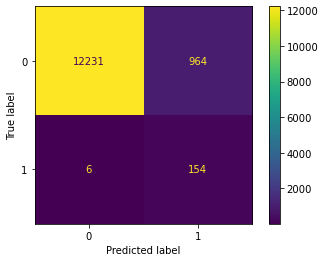

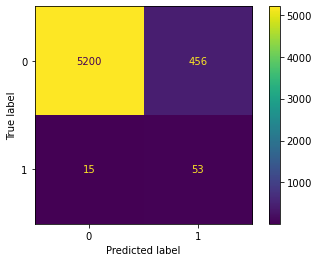

In [339]:
train_preds = best_svc_estim.predict(x_train)
test_preds = best_svc_estim.predict(x_test)
print('Training Accuracy: ', accuracy_score(y_train,train_preds),'\n',
'Testing Accuracy: ', accuracy_score(y_test,test_preds),'\n \n',

'Training Recall: ',recall_score(y_train,train_preds),'\n'
'Testing Recall: ',recall_score(y_test,test_preds),'\n \n'

'Training Precision: ',precision_score(y_train,train_preds),'\n',
'Testing Precision: ',precision_score(y_test,test_preds),'\n \n',

'Training F1 Score: ',f1_score(y_train,train_preds),'\n',
'Testing F1 Score: ',f1_score(y_test,test_preds),'\n')

plot_confusion_matrix(best_svc_estim,x_train,y_train)

plot_confusion_matrix(best_svc_estim,x_test,y_test)

# SMOTE GRID SEARCH W BEST HYPERPARAMETERS

In [349]:
svc_params = {'smote__sampling_strategy': ['all','not minority','not majority','minority','auto']}

svc_pipe = Pipeline([('preprocess', ct),
                    ('smote',SMOTE(random_state=42)),
                      ('model',
                       SVC(random_state=42,class_weight='balanced',probability=True, C = 0.1, gamma= 'scale', kernel = 'rbf'))])
cvsvc = GridSearchCV(estimator = svc_pipe, scoring = 'recall', param_grid = svc_params, cv = 3)
cvsvc.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('catpipe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['position',
                                                                          'birth_place']),
                                                                        ('numpipe',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['height', 'weight', 'birth_date', 'draft_position...
       'PIT', 'PHI', 'LAR', 'TAM', 'NWE', 'CHI', 'SFO', 'IND', 'ATL', 'DET',
       'ARI', 'CIN', 'BAL', 'MIA', 'WAS', 'JAX', 'DAL', 'TEN', 'CAR', 'RAI',
       'LAC'],
      dtype='object'))])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('model',
                                        SVC(C=0.1, class_weight='balanced',
                                            probability=True,
                                            random_state=42))]),
             param_grid={'smote__sampling_strategy': ['all', 'not minority',
                                                      'not majority',
                                                      'minority', 'auto']},
             scoring='recall')

In [350]:
best_svc = cvsvc.best_params_
best_svc_estim = cvsvc.best_estimator_
print('Best params: ',best_svc,'\n Best score: ',cvsvc.best_score_)
best_svc_estim

Best params:  {'smote__sampling_strategy': 'all'} 
 Best score:  0.7883764267412067


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('catpipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['position', 'birth_place']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['height', 'weight', 'birth_date', 'draft_position', 'draft_year',
       'passing_atte...
       'punting_blocked', 'total_games', 'win_percent', 'super_wins', 'SEA',
       'BUF', 'NOR', 'DEN', 'NYJ', 'GNB', 'HOU', 'CLE', 'MIN', 'KAN', 'NYG',
       'PIT', 'PHI', 'LAR', 'TAM', 'NWE', 'CHI', 'SFO', 'IND', 'ATL', 'DET',
       'ARI', 'CIN', 'BAL', 'MIA', 'WAS', 'JAX', 'DAL', 'TEN', 'CAR', 'RAI',
       'LAC'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42, sampling_strategy='all')),
                ('model',
                 SVC(C=0.1, class_weight='balanced', probability=True,
                     random_state=42))])

Training Accuracy:  0.9273680269561961 
 Testing Accuracy:  0.9177148846960168 
 
 Training Recall:  0.9625 
Testing Recall:  0.7794117647058824 
 
Training Precision:  0.13774597495527727 
 Testing Precision:  0.10412573673870335 
 
 Training F1 Score:  0.24100156494522687 
 Testing F1 Score:  0.18370883882149047 



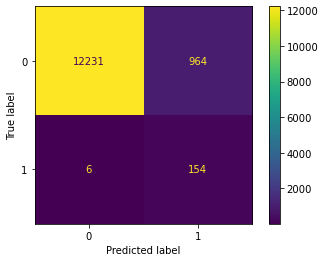

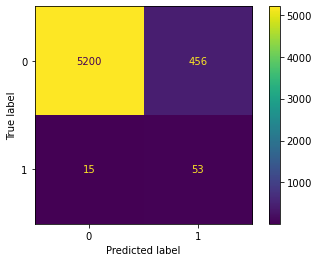

In [351]:
train_preds = best_svc_estim.predict(x_train)
test_preds = best_svc_estim.predict(x_test)
print('Training Accuracy: ', accuracy_score(y_train,train_preds),'\n',
'Testing Accuracy: ', accuracy_score(y_test,test_preds),'\n \n',

'Training Recall: ',recall_score(y_train,train_preds),'\n'
'Testing Recall: ',recall_score(y_test,test_preds),'\n \n'

'Training Precision: ',precision_score(y_train,train_preds),'\n',
'Testing Precision: ',precision_score(y_test,test_preds),'\n \n',

'Training F1 Score: ',f1_score(y_train,train_preds),'\n',
'Testing F1 Score: ',f1_score(y_test,test_preds),'\n')

plot_confusion_matrix(best_svc_estim,x_train,y_train)

plot_confusion_matrix(best_svc_estim,x_test,y_test)



In [352]:
results = pd.DataFrame(cvsvc.cv_results_).sort_values(by = 'rank_test_score')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_smote__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,72.088010,5.321967,3.893693,0.324202,all,{'smote__sampling_strategy': 'all'},0.886792,0.648148,0.830189,0.788376,0.101813,1
2,66.367556,4.715374,3.852043,0.193752,not majority,{'smote__sampling_strategy': 'not majority'},0.886792,0.648148,0.830189,0.788376,0.101813,1
3,66.478470,8.434504,3.976443,0.154928,minority,{'smote__sampling_strategy': 'minority'},0.886792,0.648148,0.830189,0.788376,0.101813,1
4,71.419047,4.057412,3.927322,0.109362,auto,{'smote__sampling_strategy': 'auto'},0.886792,0.648148,0.830189,0.788376,0.101813,1
1,17.495222,0.742417,2.397268,0.070698,not minority,{'smote__sampling_strategy': 'not minority'},0.811321,0.648148,0.754717,0.738062,0.067648,5


# TRYING INDIVIDUAL PARAMETERS OF SMOTE TO SEE POSSIBLE DIFFERENCES IN ACC, F1 AND PREC

Training Accuracy:  0.9273680269561961 
 Testing Accuracy:  0.9177148846960168 
 
 Training Recall:  0.9625 
Testing Recall:  0.7794117647058824 
 
Training Precision:  0.13774597495527727 
 Testing Precision:  0.10412573673870335 
 
 Training F1 Score:  0.24100156494522687 
 Testing F1 Score:  0.18370883882149047 



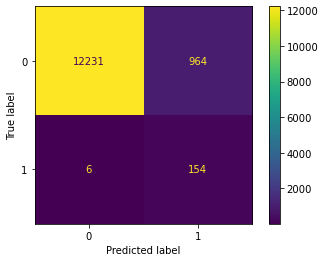

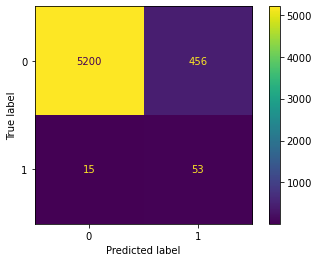

In [354]:
svc_pipe = Pipeline([('preprocess', ct),
                    ('smote',SMOTE(sampling_strategy = 'not majority', random_state=42)),
                      ('model',
                       SVC(random_state=42,class_weight='balanced',probability=True, C = 0.1, gamma= 'scale', kernel = 'rbf'))])

svc_pipe.fit(x_train,y_train)

train_preds = svc_pipe.predict(x_train)
test_preds = svc_pipe.predict(x_test)
print('Training Accuracy: ', accuracy_score(y_train,train_preds),'\n',
'Testing Accuracy: ', accuracy_score(y_test,test_preds),'\n \n',

'Training Recall: ',recall_score(y_train,train_preds),'\n'
'Testing Recall: ',recall_score(y_test,test_preds),'\n \n'

'Training Precision: ',precision_score(y_train,train_preds),'\n',
'Testing Precision: ',precision_score(y_test,test_preds),'\n \n',

'Training F1 Score: ',f1_score(y_train,train_preds),'\n',
'Testing F1 Score: ',f1_score(y_test,test_preds),'\n')

plot_confusion_matrix(svc_pipe,x_train,y_train)

plot_confusion_matrix(svc_pipe,x_test,y_test)



Training Accuracy:  0.9273680269561961 
 Testing Accuracy:  0.9177148846960168 
 
 Training Recall:  0.9625 
Testing Recall:  0.7794117647058824 
 
Training Precision:  0.13774597495527727 
 Testing Precision:  0.10412573673870335 
 
 Training F1 Score:  0.24100156494522687 
 Testing F1 Score:  0.18370883882149047 



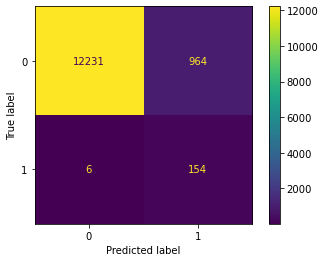

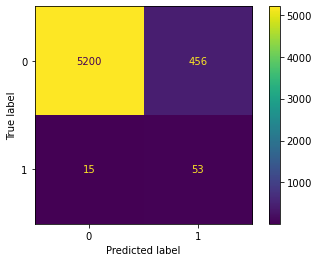

In [356]:
svc_pipe = Pipeline([('preprocess', ct),
                    ('smote',SMOTE(sampling_strategy = 'minority', random_state=42)),
                      ('model',
                       SVC(random_state=42,class_weight='balanced',probability=True, C = 0.1, gamma= 'scale', kernel = 'rbf'))])

svc_pipe.fit(x_train,y_train)

train_preds = svc_pipe.predict(x_train)
test_preds = svc_pipe.predict(x_test)
print('Training Accuracy: ', accuracy_score(y_train,train_preds),'\n',
'Testing Accuracy: ', accuracy_score(y_test,test_preds),'\n \n',

'Training Recall: ',recall_score(y_train,train_preds),'\n'
'Testing Recall: ',recall_score(y_test,test_preds),'\n \n'

'Training Precision: ',precision_score(y_train,train_preds),'\n',
'Testing Precision: ',precision_score(y_test,test_preds),'\n \n',

'Training F1 Score: ',f1_score(y_train,train_preds),'\n',
'Testing F1 Score: ',f1_score(y_test,test_preds),'\n')

plot_confusion_matrix(svc_pipe,x_train,y_train)

plot_confusion_matrix(svc_pipe,x_test,y_test)

## Model Six - Random Forest

In [ ]:
rft_params = {'model__criterion': ['entropy', 'gini'],
         'model__max_depth': [8, 9],
         'model__min_samples_split': [6, 7, 8],
         'model__warm_start': [True],
         'model__max_features': ['log2'],
         'model__min_samples_leaf': [1, 2,3]}

rft_pipe = Pipeline([('preprocess', ct),
                     ('smote',SMOTE(sampling_strategy = 'all', random_state=42)),
                      ('model',
                       RandomForestClassifier(random_state=42))])

cv3 = GridSearchCV(estimator = rft_pipe, param_grid = rft_params, cv = 5)
cv3.fit(x_train,y_train)

In [ ]:
best_rft = cv.best_params_
best3 = cv3.best_estimator_
print('Best params: ',cv3.best_params_,'\n Best score: ',cv3.best_score_)
best3

Best params:  {'model__criterion': 'gini', 'model__max_depth': 9, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 6, 'model__warm_start': True} 
Best score:  0.9687008611007114

In [ ]:
train_preds3 = best3.predict(x_train)
test_preds3 = best3.predict(x_test)


plot_confusion_matrix(best2,x_train,y_train)

plot_confusion_matrix(best2,x_test,y_test)


print('Training Accuracy: ', accuracy_score(y_train,train_preds3),'\n',
'Testing Accuracy: ', accuracy_score(y_test,test_preds3),'\n \n',

'Training Recall: ',recall_score(y_train,train_preds3),'\n'
'Testing Recall: ',recall_score(y_test,test_preds3),'\n \n'

'Training Precision: ',precision_score(y_train,train_preds3),'\n',
'Testing Precision: ',precision_score(y_test,test_preds3),'\n \n',

'Training F1 Score: ',f1_score(y_train,train_preds3),'\n',
'Testing F1 Score: ',f1_score(y_test,test_preds3),'\n')

Training Accuracy:  0.972070385623362 
 Testing Accuracy:  0.9594689028651293 
 
 Training Recall:  0.8875 
Testing Recall:  0.4117647058823529 
 
Training Precision:  0.2857142857142857 
 Testing Precision:  0.12727272727272726 
 
 Training F1 Score:  0.4322678843226788 
 Testing F1 Score:  0.19444444444444442 

## ADDITIONAL STUFF

FORESTPIPE.feature_importances_e

from imblearn.ensemble import BalancedRandomForestClassifier
model = BalancedRandomForestClassifier(n_estimators=10)

consider EASY ENSEMBLE
from imblearn.ensemble import EasyEnsembleClassifier

tree.plot_tree(model,x,y)

## Model Seven - KNN (K-NEAREST NEIGHBORS)

In [ ]:
knn_params = {'model__algorithm': ['auto'],
         'model__p': [2,3],
         'model__n_neighbors': [3,5,7],
         'model__leaf_size': [5, 10, 20]}

# Need to change pipeline
knn_pipe = Pipeline([('preprocess', ct),
                     ('smote',SMOTE(random_state=42)),
                      ('model',
                       KNeighborsClassifier())])
cvk = GridSearchCV(estimator = knn_pipe, param_grid = knn_params, cv = 5)
cvk.fit(x_train, y_train)

In [ ]:
best_KNN = cvk.best_params_
bestk = cvk.best_estimator_
print('Best params: ',cvk.best_params_,'\n Best score: ',cvk.best_score_)
bestk

Best params:  {'model__algorithm': 'auto', 'model__leaf_size': 5, 'model__n_neighbors': 3, 'model__p': 2, 'model__weights': 'distance'} 
 Best score:  0.9686259827779857

In [ ]:
train_preds = bestk.predict(x_train)
test_preds = bestk.predict(x_test)

plot_confusion_matrix(best,x_train,y_train)

plot_confusion_matrix(best,x_test,y_test)

print('Training Accuracy: ', accuracy_score(y_train,train_preds),'\n',
'Testing Accuracy: ', accuracy_score(y_test,test_preds),'\n \n',

'Training Recall: ',recall_score(y_train,train_preds),'\n'
'Testing Recall: ',recall_score(y_test,test_preds),'\n \n'

'Training Precision: ',precision_score(y_train,train_preds),'\n',
'Testing Precision: ',precision_score(y_test,test_preds),'\n \n',

'Training F1 Score: ',f1_score(y_train,train_preds),'\n',
'Testing F1 Score: ',f1_score(y_test,test_preds),'\n')

Training Accuracy:  1.0 
 Testing Accuracy:  0.9687281621243885 
 
 Training Recall:  1.0 
Testing Recall:  0.3088235294117647 
 
Training Precision:  1.0 
 Testing Precision:  0.13725490196078433 
 
 Training F1 Score:  1.0 
 Testing F1 Score:  0.1900452488687783 

# 7. Evaluation

# 8. Conclusions & Recommendations